In [1]:
# calculate elapsed time
import time
start_time = time.time()

#### IMPORT

In [2]:
import os, platform
import py7zr

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical 
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, \
    BatchNormalization, Flatten, LSTM
# from scikeras.wrappers import KerasClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

from itertools import cycle
from scipy import interp
from scipy.optimize import brentq
from scipy.interpolate import interp1d

#### PARAMETERS
- Set the condition
> * N_FEATURES: Number of Features
> * CHECK_BLANKS: Check for blank data. If any blank data is found, the whole row of data will be deleted.
> * CHECK_CLASS_IMBALANCE: Check for dataset class imbalance. The more balance the dataset, the less biases the model will be.

In [3]:
##############################
# # deep learning features # #
##############################
SEED = 1005 # random seed for reproducibility

# should make this dynamic
N_FEATURES = 220
TIMESTEPS = 1
EPOCH=400
BATCH_SIZE=10

SPLIT_RATIO=0.2

###############
# # preview # #
###############
f = False
t = True

# checking dataset
CHECK_BLANKS = True
CHECK_CLASS_IMBALANCE = True

# evaluate suitable kfold number and kfold model
MIN_KFOLD = 2
MAX_KFOLD = 11
N_KFOLD = 5
EVAL_KFOLD_NUM = False
EVAL_KFOLD_MODEL = False
PERFORM_KFOLD = True

# model testing
TEST_MODEL = True
CON_MATRIX = True
ROC_GRAPH = True

###############
# # dataset # #
###############
CLASSES_COL_NAME = "Subject"
CLASSES_COL_NUM = 0
FEATURES_COL_NUM = 2

DATASET_DIR_NAME = "dataset\set04\\11_same"
SAMPLE_DATASET_NAME = "same_train"
ACTUAL_DATASET_NAME = "same_test"

MODEL_DIR_NAME = "dataset\set04\\11_same"
MODEL_NAME = "model_" + "set04_11_same"

RESULT_DIR_NAME = "dataset\set04\\11_same"
RESULT_NAME = "result_" + "set04_11_same"

DATASET_DIR_PATH = os.path.join(os.getcwd(), DATASET_DIR_NAME)
SAMPLE_DATASET_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME + ".csv")
ACTUAL_DATASET_PATH = os.path.join(DATASET_DIR_PATH, ACTUAL_DATASET_NAME + ".csv")

MODEL_DIR_PATH = os.path.join(os.getcwd(), MODEL_DIR_NAME)
MODEL_PATH = os.path.join(MODEL_DIR_PATH, MODEL_NAME + ".h5")

RESULT_DIR_PATH = os.path.join(os.getcwd(), RESULT_DIR_NAME)
RESULT_PATH = os.path.join(RESULT_DIR_PATH, RESULT_NAME + ".csv")

#################
# # sns theme # #
#################
# sns.set_theme(style="darkgrid") # (dark background with white gridlines)
sns.set_theme(style="whitegrid") # (white background with grey gridlines)
# sns.set_theme(style="dark") # (dark background with no gridlines)
# sns.set_theme(style="white") # (white background with no gridlines)
# sns.set_theme(style="ticks") # (white background with axis ticks and no gridlines)

In [4]:
if os.path.isdir(DATASET_DIR_PATH) is True:
    print(f"Dataset directory exists at: {DATASET_DIR_PATH}")
else:
    try:
        os.mkdir(DATASET_DIR_PATH, 666)
        print(f"Dataset directory have been created at: {DATASET_DIR_PATH}")
    except:
        print("Error: Dataset Directory not created")
        
if os.path.isdir(MODEL_DIR_PATH) is True:
    print(f"Model directory exists at: {MODEL_DIR_PATH}")
else:
    try:
        os.mkdir(MODEL_DIR_PATH, 666)
        print(f"Model directory have been created at: {MODEL_DIR_PATH}")
    except:
        print("Error: Model Directory not created")
    
if os.path.exists(SAMPLE_DATASET_PATH) is True:
    print(f"Training dataset exists at: {SAMPLE_DATASET_PATH}")
else:
    try:
        SAMPLE_7Z_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME + ".7z")
        with py7zr.SevenZipFile(SAMPLE_7Z_PATH, mode='r') as z:
            z.extractall(path=DATASET_DIR_PATH)
        print(f"Decompress 7z file to: {SAMPLE_7Z_PATH}")
    except:
        print("Error: Failed to decompress 7z file.")

Dataset directory exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set04\11_same
Model directory exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set04\11_same
Training dataset exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set04\11_same\same_train.csv


#### CREATE MODEL
- Create base model
- Wrap it with KerasClassifier

In [5]:
#create base model
def create_base_model():
    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True,
             input_shape=(TIMESTEPS,N_FEATURES)))
    model.add(Dense(256, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dense(128, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dense(64, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=32, return_sequences=True))
    model.add(Dense(32, activation='sigmoid'))
    model.add(Dropout(0.2))

    # softmax for multi-class classification
    model.add(Flatten())
    print("There are a total of " + str(n_classes) + " classes.")
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])
    return model

# wrap model in KerasClassifier
def create_model():
    model = KerasClassifier(build_fn=create_base_model, epochs=EPOCH, 
                            batch_size=BATCH_SIZE)
    return model

In [6]:
# divide data into features X and target (classes) Y
def prepare_dataset(df):
    X = df.values[:,FEATURES_COL_NUM:].astype(float)
    Y = df.values[:,CLASSES_COL_NUM].astype(str)

    # convert target Y to labelbinarizer Y for model
    # fit_transform is not used to reuse lb
    Y = Y.reshape(-1, 1)
    lb = LabelBinarizer().fit(Y)
    Y = lb.transform(Y)

    #################################
    # # get all the encoded class # #
    #################################
    print("LabelBinarizer is able to decipher: ")
    print(lb.classes_)
    print("\n")

    ###########################
    # # print X and Y shape # #
    ###########################
    print(f"X | Features | Dataset Shape: {X.shape}")
    print(f"Y | Classes  | Dataset Shape: {Y.shape}")

    return X, Y, lb, lb.classes_.tolist()

In [7]:
def split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED):

    ##############################################################
    # # split dataset into train and test set of 0.8/0.2 ratio # #
    ##############################################################
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=SPLIT_RATIO, random_state=SEED)

    ############################
    # # reshaping of dataset # #
    ############################

    # reshaping the dataset to include LSTM Timesteps
    print(X_train.dtype)
    X_train = np.asarray(X_train, dtype=np.float32)
    print(X_train.dtype)
    X_train = np.reshape(X_train, (X_train.shape[0], TIMESTEPS, X_train.shape[1]))
    print(X_test.dtype)
    X_test = np.asarray(X_test, dtype=np.float32)
    print(X_test.dtype)
    X_test = np.reshape(X_test, (X_test.shape[0], TIMESTEPS, X_test.shape[1]))

    print(f"X train shape: {X_train.shape}")
    print(f"Y train shape: {y_train.shape}")
    print(f"X test shape: {X_test.shape}")
    print(f"Y test shape: {y_test.shape}")
    
    return X_train, X_test, y_train, y_test

def reshape_dataset(X, TIMESTEPS):
    # reshaping the dataset to include LSTM Timesteps
    X = np.asarray(X, dtype=np.float32)
    X = np.reshape(X, (X.shape[0], TIMESTEPS, X.shape[1]))
    return X

#### LOAD DATASET

In [8]:
# load dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)
df.head()

,Subject,Password,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-NG|0+1,T2-D|1,T2-I|1+2,T2-PF|1+2,...,T7-RF|VAR,T7-NG|VAR,T7-I|SD,T7-PF|SD,T7-RF|SD,T7-NG|SD,T8-I|0+7,T8-PF|0+7,T8-RF|0+7,T8-NG|0+7
0,andy,dEcisi0n,0.078293,0.123274,0.201567,0.235551,0.313844,0.112277,0.067947,0.180224,...,0.014072,0.008948,0.126700,0.102669,0.118626,0.094595,0.889900,0.968193,0.989548,1.067841
1,andy,dEcisi0n,0.089872,0.135437,0.225308,0.203912,0.293784,0.068475,0.088657,0.157132,...,0.011081,0.014495,0.065051,0.080180,0.105265,0.120395,0.856497,0.946369,0.933958,1.023829
2,andy,dEcisi0n,0.100823,0.100237,0.201061,0.201381,0.302204,0.101144,0.044354,0.145498,...,0.012190,0.012140,0.086086,0.085859,0.110409,0.110182,0.742216,0.843040,0.808707,0.909530
3,andy,dEcisi0n,0.090142,0.112780,0.202921,0.192025,0.282167,0.079245,0.111987,0.191232,...,0.009144,0.010677,0.080989,0.088693,0.095626,0.103331,0.833344,0.923486,0.900271,0.990412
4,andy,dEcisi0n,0.077035,0.124322,0.201357,0.213968,0.291003,0.089646,0.057870,0.147516,...,0.009157,0.007530,0.120318,0.111400,0.095693,0.086775,0.743791,0.820826,0.833329,0.910364


#### CHECK DATASET

Checking for blanks...
No blank value has been found.
Checking for class imbalance...


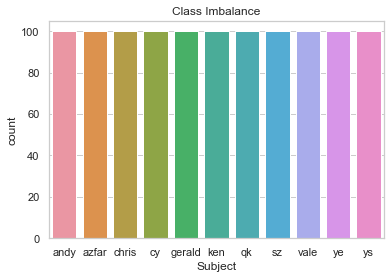

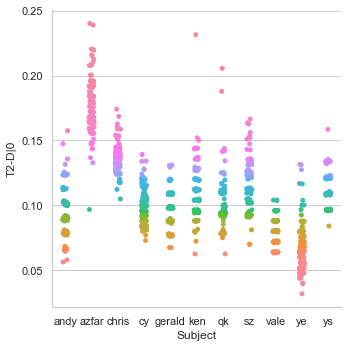

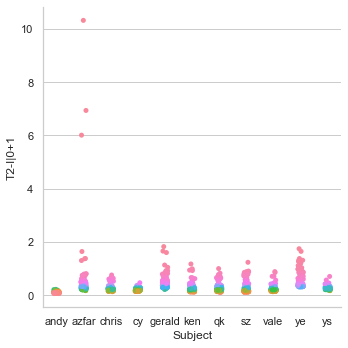

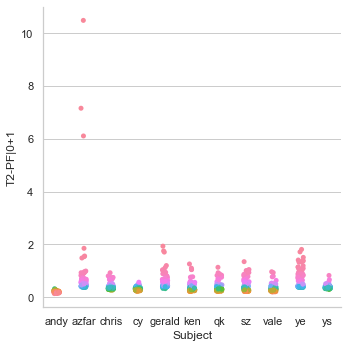

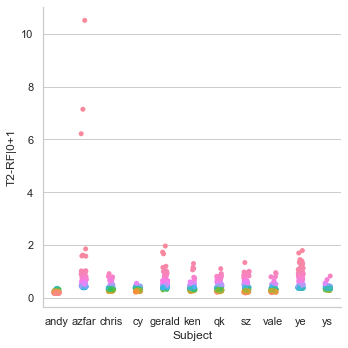

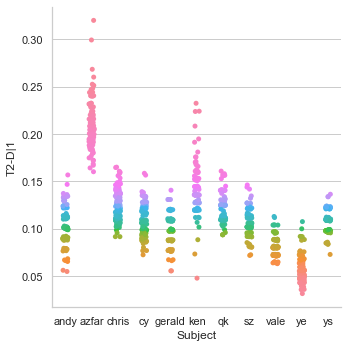

In [9]:
########################
# # check for blanks # #
########################
if CHECK_BLANKS is True:
    # checking for blanks
    print("Checking for blanks...")
    if df.isnull().values.any() is True:
        df = df.dropna(axis=0, how="any")
        print("Blank rows has been dropped.")
    else:
        print("No blank value has been found.")
        
#################################
# # check for class imbalance # #
#################################
if CHECK_CLASS_IMBALANCE is True:
    print("Checking for class imbalance...")
    sns.countplot(x=CLASSES_COL_NAME, data=df).set_title("Class Imbalance")
#     df.loc[(df!=0).any(axis=1)]
    plt.show()

sns.catplot(x="Subject", y="T2-D|0", hue="T2-D|0", data=df, legend=False)
sns.catplot(x="Subject", y="T2-I|0+1", hue="T2-I|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-PF|0+1", hue="T2-PF|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-RF|0+1", hue="T2-RF|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-D|1", hue="T2-D|1", data=df, legend=False)

#### PREPARE DATASET
- Split data based on X / Features and Y / Classes
- Binarize Y into binary labels

In [10]:
X, Y, lb, class_list = prepare_dataset(df)
n_classes = len(class_list)
print(f"Number of Classes: {n_classes}")

LabelBinarizer is able to decipher: 
['andy' 'azfar' 'chris' 'cy' 'gerald' 'ken' 'qk' 'sz' 'vale' 'ye' 'ys']


X | Features | Dataset Shape: (1100, 220)
Y | Classes  | Dataset Shape: (1100, 11)
Number of Classes: 11


#### SPLIT DATASET
- Split dataset into train set and test set 0.8 / 0.2

In [11]:
##############################################################
# # split dataset into train and test set of 0.8/0.2 ratio # #
##############################################################
X_train, X_test, y_train, y_test = split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED)

float64
float32
float64
float32
X train shape: (880, 1, 220)
Y train shape: (880, 11)
X test shape: (220, 1, 220)
Y test shape: (220, 11)


#### PERFORM VALIDATION (w KFold Validation)
- Evaluate best KFold Validation
- Generate loss and accuracy graph
- Perform KFold validation

##### Evaluate suitable folds for kfold validation

In [12]:
###############################################
# # evaluate suitable kfold value for model # #
###############################################
def evaluate_kfold(X_train, y_train, SEED, MIN_KFOLD, MAX_KFOLD):
    
    # evaluate the model    
    folds = range(MIN_KFOLD, MAX_KFOLD)
    means, mins, maxs = list(), list(), list()
    
    # evaluate each k value
    for k in folds:
        # define the test condition
        kfold = KFold(n_splits=k, shuffle=True, random_state=SEED)
        
        # evaluate k value
        model = create_model()
        scores = cross_val_score(model, X_train, y_train, cv=kfold, n_jobs=-1)
        
        k_mean = np.mean(scores)
        k_min = scores.min()
        k_max = scores.max()
        
        # report performance
        print(f"No. of Folds: {k} | Accuracy: {k_mean*100:.3f} | Min: {k_min*100:.3f} | Max: {k_max*100:.3f}")
        
        # store mean accuracy and min and max relative to the mean
        means.append(k_mean)
        mins.append(k_mean - k_min)
        maxs.append(k_max - k_mean)
        
    # line plot of k mean values with min/max error bars
    clear_output(wait=True)
    pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
    
    # show the plot
    pyplot.show()
    
if EVAL_KFOLD_NUM is True:
    evaluate_kfold(X_train, y_train, SEED, MIN_KFOLD, MAX_KFOLD)
else:
    print("EVAL_KFOLD_NUM is not True")

EVAL_KFOLD_NUM is not True


##### Generate kfold validation accuracy and loss

In [13]:
##################################################
# # evaluate kfold model for accuracy and loss # #
##################################################
def evaluate_kfold_model(X_train, y_train, SEED):
    scores, histories = list(), list()
    # create model
    model = create_model()
    # prepare cross validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
    # enumerate splits
    for train_ix, test_ix in kfold.split(X_train):
        # select rows for train and test
        trainX, trainY, testX, testY = X_train[train_ix], y_train[train_ix], X_train[test_ix], y_train[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=100, batch_size=50, validation_data=(testX, testY), verbose=0)
        
        # evaluate model
        y_pred = model.predict(testX)
        y_pred = to_categorical(y_pred)

        # evaluate predictions
        acc = accuracy_score(testY, y_pred)
        print("Testing accuracy: %.3f%%" % (acc*100))

        # stores scores and histories
        scores.append(acc)
        histories.append(history)

    for i in range(len(histories)):
        # plot loss
        f1 = plt.figure(1)
        plt.title('Categorical Cross-Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue')
        plt.plot(histories[i].history['val_loss'], color='orange')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')

        # plot accuracy
        f2 = plt.figure(2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue')
        plt.plot(histories[i].history['val_accuracy'], color='orange')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='lower right')

    # print summary
    print(f"Accuracy | Mean: {np.mean(scores)*100:.3f} | Std: {np.std(scores)*100:.3f} | Length/no.: {len(scores)}")
    # box and whisker plots of results
    f3 = plt.figure(3)
    plt.title('Box and Whisker Plot of Accuracy Scores')
    plt.ylabel('accuracy')
    plt.xlabel('model')
    plt.boxplot(scores)
    clear_output(wait=True)
    plt.show()
    
if EVAL_KFOLD_MODEL is True:
    evaluate_kfold_model(X_train, y_train, SEED)
else:
    print("EVAL_KFOLD_MODEL is not true")

EVAL_KFOLD_MODEL is not true


##### Perform Actual KFold validation

In [14]:
if PERFORM_KFOLD is True:
    # create model
    model = create_model()
    kfold = KFold(n_splits=N_KFOLD, shuffle=True, random_state=SEED)
    valid_score = cross_val_score(model, X_train, y_train, 
                          cv=kfold, error_score="raise", verbose=0)
else:
    print("PERFORM_KFOLD is not true.")

There are a total of 11 classes.
Epoch 1/400
71/71 [==============================] - 7s 10ms/step - loss: 2.5311 - accuracy: 0.1023
Epoch 2/400
71/71 [==============================] - 1s 10ms/step - loss: 2.4337 - accuracy: 0.0824
Epoch 3/400
71/71 [==============================] - 1s 10ms/step - loss: 2.4228 - accuracy: 0.1122
Epoch 4/400
71/71 [==============================] - 1s 10ms/step - loss: 2.3650 - accuracy: 0.1307
Epoch 5/400
71/71 [==============================] - 1s 10ms/step - loss: 2.3139 - accuracy: 0.1506
Epoch 6/400
71/71 [==============================] - 1s 10ms/step - loss: 2.2264 - accuracy: 0.1733
Epoch 7/400
71/71 [==============================] - 1s 10ms/step - loss: 2.1536 - accuracy: 0.2188
Epoch 8/400
71/71 [==============================] - 1s 10ms/step - loss: 2.1010 - accuracy: 0.1918
Epoch 9/400
71/71 [==============================] - 1s 10ms/step - loss: 2.0345 - accuracy: 0.2514
Epoch 10/400
71/71 [==============================] - 1s 10ms/step 

71/71 [==============================] - 1s 9ms/step - loss: 1.6580 - accuracy: 0.3636
Epoch 83/400
71/71 [==============================] - 1s 10ms/step - loss: 1.5866 - accuracy: 0.3707
Epoch 84/400
71/71 [==============================] - 1s 9ms/step - loss: 1.5611 - accuracy: 0.4190
Epoch 85/400
71/71 [==============================] - 1s 10ms/step - loss: 1.5090 - accuracy: 0.4134
Epoch 86/400
71/71 [==============================] - 1s 10ms/step - loss: 1.5751 - accuracy: 0.3849
Epoch 87/400
71/71 [==============================] - 1s 10ms/step - loss: 1.5481 - accuracy: 0.3636
Epoch 88/400
71/71 [==============================] - 1s 10ms/step - loss: 1.5421 - accuracy: 0.3793
Epoch 89/400
71/71 [==============================] - 1s 9ms/step - loss: 1.5337 - accuracy: 0.3878
Epoch 90/400
71/71 [==============================] - 1s 10ms/step - loss: 1.5600 - accuracy: 0.3793
Epoch 91/400
71/71 [==============================] - 1s 10ms/step - loss: 1.4930 - accuracy: 0.4119
Epoch 

71/71 [==============================] - 1s 18ms/step - loss: 1.3310 - accuracy: 0.5256
Epoch 164/400
71/71 [==============================] - 1s 18ms/step - loss: 1.1967 - accuracy: 0.5866
Epoch 165/400
71/71 [==============================] - 1s 18ms/step - loss: 1.1560 - accuracy: 0.6009
Epoch 166/400
71/71 [==============================] - 1s 18ms/step - loss: 1.2110 - accuracy: 0.5554
Epoch 167/400
71/71 [==============================] - 1s 17ms/step - loss: 1.1615 - accuracy: 0.5881
Epoch 168/400
71/71 [==============================] - 1s 17ms/step - loss: 1.3168 - accuracy: 0.5710
Epoch 169/400
71/71 [==============================] - 1s 17ms/step - loss: 1.1796 - accuracy: 0.5909
Epoch 170/400
71/71 [==============================] - 1s 18ms/step - loss: 1.1615 - accuracy: 0.5966
Epoch 171/400
71/71 [==============================] - 1s 17ms/step - loss: 1.1821 - accuracy: 0.5980
Epoch 172/400
71/71 [==============================] - 1s 17ms/step - loss: 1.2104 - accuracy: 0

71/71 [==============================] - 1s 10ms/step - loss: 0.9950 - accuracy: 0.6534
Epoch 244/400
71/71 [==============================] - 1s 10ms/step - loss: 0.9786 - accuracy: 0.6662
Epoch 245/400
71/71 [==============================] - 1s 9ms/step - loss: 1.0106 - accuracy: 0.6662
Epoch 246/400
71/71 [==============================] - 1s 10ms/step - loss: 0.9880 - accuracy: 0.6733
Epoch 247/400
71/71 [==============================] - 1s 9ms/step - loss: 0.9489 - accuracy: 0.6832
Epoch 248/400
71/71 [==============================] - 1s 9ms/step - loss: 0.9360 - accuracy: 0.6847
Epoch 249/400
71/71 [==============================] - 1s 9ms/step - loss: 1.0049 - accuracy: 0.6776
Epoch 250/400
71/71 [==============================] - 1s 9ms/step - loss: 0.9921 - accuracy: 0.6378
Epoch 251/400
71/71 [==============================] - 1s 9ms/step - loss: 1.0167 - accuracy: 0.6392
Epoch 252/400
71/71 [==============================] - 1s 10ms/step - loss: 1.0981 - accuracy: 0.6179


71/71 [==============================] - 1s 12ms/step - loss: 0.8229 - accuracy: 0.7159
Epoch 324/400
71/71 [==============================] - 1s 10ms/step - loss: 0.8478 - accuracy: 0.7244
Epoch 325/400
71/71 [==============================] - 1s 10ms/step - loss: 0.8338 - accuracy: 0.7074
Epoch 326/400
71/71 [==============================] - 1s 10ms/step - loss: 0.8315 - accuracy: 0.7088
Epoch 327/400
71/71 [==============================] - 1s 10ms/step - loss: 0.7894 - accuracy: 0.7216
Epoch 328/400
71/71 [==============================] - 1s 10ms/step - loss: 0.7919 - accuracy: 0.7259
Epoch 329/400
71/71 [==============================] - 1s 9ms/step - loss: 0.8291 - accuracy: 0.7216
Epoch 330/400
71/71 [==============================] - 1s 9ms/step - loss: 0.7643 - accuracy: 0.7358
Epoch 331/400
71/71 [==============================] - 1s 10ms/step - loss: 0.7833 - accuracy: 0.7173
Epoch 332/400
71/71 [==============================] - 1s 9ms/step - loss: 0.8766 - accuracy: 0.71

71/71 [==============================] - 1s 9ms/step - loss: 2.4369 - accuracy: 0.1037
Epoch 3/400
71/71 [==============================] - 1s 9ms/step - loss: 2.3717 - accuracy: 0.1264
Epoch 4/400
71/71 [==============================] - 1s 9ms/step - loss: 2.2388 - accuracy: 0.1605
Epoch 5/400
71/71 [==============================] - 1s 9ms/step - loss: 2.1671 - accuracy: 0.1619
Epoch 6/400
71/71 [==============================] - 1s 9ms/step - loss: 2.1295 - accuracy: 0.1790
Epoch 7/400
71/71 [==============================] - 1s 9ms/step - loss: 2.0850 - accuracy: 0.1847
Epoch 8/400
71/71 [==============================] - 1s 9ms/step - loss: 2.0824 - accuracy: 0.1761
Epoch 9/400
71/71 [==============================] - 1s 13ms/step - loss: 2.0483 - accuracy: 0.1761
Epoch 10/400
71/71 [==============================] - 1s 11ms/step - loss: 2.0556 - accuracy: 0.1847
Epoch 11/400
71/71 [==============================] - 1s 11ms/step - loss: 2.0279 - accuracy: 0.2003
Epoch 12/400
71/7

71/71 [==============================] - 1s 11ms/step - loss: 1.6669 - accuracy: 0.3082
Epoch 84/400
71/71 [==============================] - 1s 10ms/step - loss: 1.5971 - accuracy: 0.3565
Epoch 85/400
71/71 [==============================] - 1s 11ms/step - loss: 1.6645 - accuracy: 0.3395
Epoch 86/400
71/71 [==============================] - 1s 10ms/step - loss: 1.5999 - accuracy: 0.3438
Epoch 87/400
71/71 [==============================] - 1s 11ms/step - loss: 1.5988 - accuracy: 0.3821
Epoch 88/400
71/71 [==============================] - 1s 10ms/step - loss: 1.5815 - accuracy: 0.3878
Epoch 89/400
71/71 [==============================] - 1s 11ms/step - loss: 1.6204 - accuracy: 0.3537
Epoch 90/400
71/71 [==============================] - 1s 11ms/step - loss: 1.6177 - accuracy: 0.3466
Epoch 91/400
71/71 [==============================] - 1s 10ms/step - loss: 1.5662 - accuracy: 0.3580
Epoch 92/400
71/71 [==============================] - 1s 11ms/step - loss: 1.5795 - accuracy: 0.3537
Epo

71/71 [==============================] - 1s 11ms/step - loss: 1.3820 - accuracy: 0.4332
Epoch 164/400
71/71 [==============================] - 1s 11ms/step - loss: 1.3633 - accuracy: 0.4773
Epoch 165/400
71/71 [==============================] - 1s 11ms/step - loss: 1.4496 - accuracy: 0.4105
Epoch 166/400
71/71 [==============================] - 1s 11ms/step - loss: 1.3315 - accuracy: 0.4446
Epoch 167/400
71/71 [==============================] - 1s 11ms/step - loss: 1.3575 - accuracy: 0.4631
Epoch 168/400
71/71 [==============================] - 1s 11ms/step - loss: 1.2997 - accuracy: 0.4716
Epoch 169/400
71/71 [==============================] - 1s 11ms/step - loss: 1.3326 - accuracy: 0.4602
Epoch 170/400
71/71 [==============================] - 1s 10ms/step - loss: 1.3338 - accuracy: 0.4503
Epoch 171/400
71/71 [==============================] - 1s 11ms/step - loss: 1.3527 - accuracy: 0.4659
Epoch 172/400
71/71 [==============================] - 1s 10ms/step - loss: 1.3141 - accuracy: 0

71/71 [==============================] - 1s 12ms/step - loss: 1.1321 - accuracy: 0.6321
Epoch 244/400
71/71 [==============================] - 1s 11ms/step - loss: 1.0513 - accuracy: 0.6179
Epoch 245/400
71/71 [==============================] - 1s 11ms/step - loss: 1.1071 - accuracy: 0.6051
Epoch 246/400
71/71 [==============================] - 1s 11ms/step - loss: 1.1029 - accuracy: 0.6179
Epoch 247/400
71/71 [==============================] - 1s 11ms/step - loss: 1.0402 - accuracy: 0.6179
Epoch 248/400
71/71 [==============================] - 1s 11ms/step - loss: 1.0109 - accuracy: 0.6364
Epoch 249/400
71/71 [==============================] - 1s 11ms/step - loss: 1.0858 - accuracy: 0.6122
Epoch 250/400
71/71 [==============================] - 1s 11ms/step - loss: 1.0080 - accuracy: 0.6591
Epoch 251/400
71/71 [==============================] - 1s 11ms/step - loss: 1.0090 - accuracy: 0.6506
Epoch 252/400
71/71 [==============================] - 1s 11ms/step - loss: 0.9726 - accuracy: 0

71/71 [==============================] - 1s 11ms/step - loss: 0.9339 - accuracy: 0.6818
Epoch 324/400
71/71 [==============================] - 1s 11ms/step - loss: 0.8808 - accuracy: 0.6989
Epoch 325/400
71/71 [==============================] - 1s 11ms/step - loss: 0.9377 - accuracy: 0.6776
Epoch 326/400
71/71 [==============================] - 1s 12ms/step - loss: 0.8692 - accuracy: 0.7060
Epoch 327/400
71/71 [==============================] - 1s 11ms/step - loss: 0.9352 - accuracy: 0.6790
Epoch 328/400
71/71 [==============================] - 1s 11ms/step - loss: 0.9680 - accuracy: 0.6634
Epoch 329/400
71/71 [==============================] - 1s 11ms/step - loss: 0.9093 - accuracy: 0.6705
Epoch 330/400
71/71 [==============================] - 1s 11ms/step - loss: 0.8725 - accuracy: 0.6946
Epoch 331/400
71/71 [==============================] - 1s 11ms/step - loss: 0.8373 - accuracy: 0.6932
Epoch 332/400
71/71 [==============================] - 1s 11ms/step - loss: 0.8431 - accuracy: 0

71/71 [==============================] - 1s 13ms/step - loss: 2.4486 - accuracy: 0.1193
Epoch 3/400
71/71 [==============================] - 1s 13ms/step - loss: 2.4054 - accuracy: 0.1065
Epoch 4/400
71/71 [==============================] - 1s 13ms/step - loss: 2.3271 - accuracy: 0.1420
Epoch 5/400
71/71 [==============================] - 1s 12ms/step - loss: 2.3046 - accuracy: 0.1222
Epoch 6/400
71/71 [==============================] - 1s 12ms/step - loss: 2.2628 - accuracy: 0.1236
Epoch 7/400
71/71 [==============================] - 1s 12ms/step - loss: 2.1656 - accuracy: 0.1889
Epoch 8/400
71/71 [==============================] - 1s 12ms/step - loss: 2.1232 - accuracy: 0.1946
Epoch 9/400
71/71 [==============================] - 1s 11ms/step - loss: 2.0874 - accuracy: 0.2074
Epoch 10/400
71/71 [==============================] - 1s 12ms/step - loss: 2.0983 - accuracy: 0.1804
Epoch 11/400
71/71 [==============================] - 1s 13ms/step - loss: 2.0977 - accuracy: 0.2003
Epoch 12/4

71/71 [==============================] - 1s 15ms/step - loss: 1.5654 - accuracy: 0.3835
Epoch 84/400
71/71 [==============================] - 1s 13ms/step - loss: 1.5588 - accuracy: 0.3722
Epoch 85/400
71/71 [==============================] - 1s 15ms/step - loss: 1.6003 - accuracy: 0.3864
Epoch 86/400
71/71 [==============================] - 1s 15ms/step - loss: 1.5689 - accuracy: 0.3665
Epoch 87/400
71/71 [==============================] - 1s 14ms/step - loss: 1.6089 - accuracy: 0.3636
Epoch 88/400
71/71 [==============================] - 1s 15ms/step - loss: 1.5551 - accuracy: 0.3878
Epoch 89/400
71/71 [==============================] - 1s 15ms/step - loss: 1.5505 - accuracy: 0.3906
Epoch 90/400
71/71 [==============================] - 1s 13ms/step - loss: 1.5941 - accuracy: 0.3665
Epoch 91/400
71/71 [==============================] - 1s 12ms/step - loss: 1.5806 - accuracy: 0.3906
Epoch 92/400
71/71 [==============================] - 1s 14ms/step - loss: 1.5094 - accuracy: 0.4077
Epo

71/71 [==============================] - 1s 11ms/step - loss: 1.2756 - accuracy: 0.5497
Epoch 164/400
71/71 [==============================] - 1s 11ms/step - loss: 1.2205 - accuracy: 0.5696
Epoch 165/400
71/71 [==============================] - 1s 12ms/step - loss: 1.2036 - accuracy: 0.5526
Epoch 166/400
71/71 [==============================] - 1s 11ms/step - loss: 1.2799 - accuracy: 0.5554
Epoch 167/400
71/71 [==============================] - 1s 11ms/step - loss: 1.2751 - accuracy: 0.5568
Epoch 168/400
71/71 [==============================] - 1s 11ms/step - loss: 1.3701 - accuracy: 0.4986
Epoch 169/400
71/71 [==============================] - 1s 11ms/step - loss: 1.2845 - accuracy: 0.5327
Epoch 170/400
71/71 [==============================] - 1s 10ms/step - loss: 1.3159 - accuracy: 0.5526
Epoch 171/400
71/71 [==============================] - 1s 11ms/step - loss: 1.2758 - accuracy: 0.5554
Epoch 172/400
71/71 [==============================] - 1s 11ms/step - loss: 1.3438 - accuracy: 0

71/71 [==============================] - 1s 11ms/step - loss: 0.9862 - accuracy: 0.6435
Epoch 244/400
71/71 [==============================] - 1s 11ms/step - loss: 1.0063 - accuracy: 0.6520
Epoch 245/400
71/71 [==============================] - 1s 11ms/step - loss: 1.0113 - accuracy: 0.6705
Epoch 246/400
71/71 [==============================] - 1s 11ms/step - loss: 1.3100 - accuracy: 0.5710
Epoch 247/400
71/71 [==============================] - 1s 12ms/step - loss: 1.1111 - accuracy: 0.6335
Epoch 248/400
71/71 [==============================] - 1s 11ms/step - loss: 1.0669 - accuracy: 0.6321
Epoch 249/400
71/71 [==============================] - 1s 11ms/step - loss: 1.0602 - accuracy: 0.6293
Epoch 250/400
71/71 [==============================] - 1s 11ms/step - loss: 1.1396 - accuracy: 0.6250
Epoch 251/400
71/71 [==============================] - 1s 12ms/step - loss: 1.0973 - accuracy: 0.6108
Epoch 252/400
71/71 [==============================] - 1s 11ms/step - loss: 1.0627 - accuracy: 0

71/71 [==============================] - 1s 12ms/step - loss: 0.8116 - accuracy: 0.7202
Epoch 324/400
71/71 [==============================] - 1s 11ms/step - loss: 0.9182 - accuracy: 0.6733
Epoch 325/400
71/71 [==============================] - 1s 11ms/step - loss: 0.9104 - accuracy: 0.6747
Epoch 326/400
71/71 [==============================] - 1s 11ms/step - loss: 0.8954 - accuracy: 0.6847
Epoch 327/400
71/71 [==============================] - 1s 11ms/step - loss: 0.8910 - accuracy: 0.6875
Epoch 328/400
71/71 [==============================] - 1s 11ms/step - loss: 0.8961 - accuracy: 0.6705
Epoch 329/400
71/71 [==============================] - 1s 11ms/step - loss: 0.8942 - accuracy: 0.6790
Epoch 330/400
71/71 [==============================] - 1s 12ms/step - loss: 1.0213 - accuracy: 0.6520
Epoch 331/400
71/71 [==============================] - 1s 12ms/step - loss: 1.0158 - accuracy: 0.6463
Epoch 332/400
71/71 [==============================] - 1s 12ms/step - loss: 0.9945 - accuracy: 0

71/71 [==============================] - 1s 12ms/step - loss: 2.4478 - accuracy: 0.0866
Epoch 3/400
71/71 [==============================] - 1s 13ms/step - loss: 2.4412 - accuracy: 0.0938
Epoch 4/400
71/71 [==============================] - 1s 13ms/step - loss: 2.3712 - accuracy: 0.1349
Epoch 5/400
71/71 [==============================] - 1s 14ms/step - loss: 2.3303 - accuracy: 0.1690
Epoch 6/400
71/71 [==============================] - 1s 15ms/step - loss: 2.2375 - accuracy: 0.1889
Epoch 7/400
71/71 [==============================] - 1s 16ms/step - loss: 2.1518 - accuracy: 0.2088
Epoch 8/400
71/71 [==============================] - 1s 13ms/step - loss: 2.1337 - accuracy: 0.1861
Epoch 9/400
71/71 [==============================] - 1s 13ms/step - loss: 2.0832 - accuracy: 0.2145
Epoch 10/400
71/71 [==============================] - 1s 11ms/step - loss: 2.0197 - accuracy: 0.2188
Epoch 11/400
71/71 [==============================] - 1s 13ms/step - loss: 1.9937 - accuracy: 0.2358
Epoch 12/4

71/71 [==============================] - 1s 14ms/step - loss: 1.6347 - accuracy: 0.3480
Epoch 84/400
71/71 [==============================] - 1s 14ms/step - loss: 1.6870 - accuracy: 0.3594
Epoch 85/400
71/71 [==============================] - 1s 15ms/step - loss: 1.6706 - accuracy: 0.3054
Epoch 86/400
71/71 [==============================] - 1s 15ms/step - loss: 1.6857 - accuracy: 0.3338
Epoch 87/400
71/71 [==============================] - 1s 15ms/step - loss: 1.6478 - accuracy: 0.3537
Epoch 88/400
71/71 [==============================] - 1s 15ms/step - loss: 1.5788 - accuracy: 0.3594
Epoch 89/400
71/71 [==============================] - 1s 15ms/step - loss: 1.6432 - accuracy: 0.3565
Epoch 90/400
71/71 [==============================] - 1s 14ms/step - loss: 1.6302 - accuracy: 0.3480
Epoch 91/400
71/71 [==============================] - 1s 15ms/step - loss: 1.6345 - accuracy: 0.3580
Epoch 92/400
71/71 [==============================] - 1s 15ms/step - loss: 1.5917 - accuracy: 0.3423
Epo

71/71 [==============================] - 1s 12ms/step - loss: 1.4611 - accuracy: 0.4688
Epoch 164/400
71/71 [==============================] - 1s 13ms/step - loss: 1.3570 - accuracy: 0.4901
Epoch 165/400
71/71 [==============================] - 1s 12ms/step - loss: 1.4571 - accuracy: 0.4730
Epoch 166/400
71/71 [==============================] - 1s 11ms/step - loss: 1.3416 - accuracy: 0.5071
Epoch 167/400
71/71 [==============================] - 1s 12ms/step - loss: 1.4377 - accuracy: 0.4872
Epoch 168/400
71/71 [==============================] - 1s 11ms/step - loss: 1.3232 - accuracy: 0.4858
Epoch 169/400
71/71 [==============================] - 1s 12ms/step - loss: 1.4333 - accuracy: 0.4645
Epoch 170/400
71/71 [==============================] - 1s 11ms/step - loss: 1.3469 - accuracy: 0.4844
Epoch 171/400
71/71 [==============================] - 1s 12ms/step - loss: 1.2925 - accuracy: 0.5185
Epoch 172/400
71/71 [==============================] - 1s 12ms/step - loss: 1.3136 - accuracy: 0

71/71 [==============================] - 1s 11ms/step - loss: 1.1528 - accuracy: 0.6080
Epoch 244/400
71/71 [==============================] - 1s 11ms/step - loss: 1.2038 - accuracy: 0.5810
Epoch 245/400
71/71 [==============================] - 1s 12ms/step - loss: 1.0635 - accuracy: 0.6307
Epoch 246/400
71/71 [==============================] - 1s 12ms/step - loss: 1.0480 - accuracy: 0.6065
Epoch 247/400
71/71 [==============================] - 1s 11ms/step - loss: 1.1097 - accuracy: 0.6037
Epoch 248/400
71/71 [==============================] - 1s 12ms/step - loss: 1.0351 - accuracy: 0.6491
Epoch 249/400
71/71 [==============================] - 1s 11ms/step - loss: 1.1555 - accuracy: 0.6136
Epoch 250/400
71/71 [==============================] - 1s 11ms/step - loss: 1.1214 - accuracy: 0.6009
Epoch 251/400
71/71 [==============================] - 1s 11ms/step - loss: 1.0816 - accuracy: 0.6179
Epoch 252/400
71/71 [==============================] - 1s 11ms/step - loss: 1.0901 - accuracy: 0

71/71 [==============================] - 1s 11ms/step - loss: 0.9048 - accuracy: 0.6733
Epoch 324/400
71/71 [==============================] - 1s 11ms/step - loss: 0.9599 - accuracy: 0.6648
Epoch 325/400
71/71 [==============================] - 1s 11ms/step - loss: 0.9076 - accuracy: 0.6989
Epoch 326/400
71/71 [==============================] - 1s 11ms/step - loss: 0.9397 - accuracy: 0.6577
Epoch 327/400
71/71 [==============================] - 1s 11ms/step - loss: 1.0769 - accuracy: 0.6122
Epoch 328/400
71/71 [==============================] - 1s 11ms/step - loss: 1.0085 - accuracy: 0.6378
Epoch 329/400
71/71 [==============================] - 1s 11ms/step - loss: 0.9566 - accuracy: 0.6548
Epoch 330/400
71/71 [==============================] - 1s 11ms/step - loss: 0.9709 - accuracy: 0.6761
Epoch 331/400
71/71 [==============================] - 1s 11ms/step - loss: 0.8873 - accuracy: 0.6903
Epoch 332/400
71/71 [==============================] - 1s 11ms/step - loss: 0.9646 - accuracy: 0

71/71 [==============================] - 1s 12ms/step - loss: 2.4552 - accuracy: 0.0866
Epoch 3/400
71/71 [==============================] - 1s 12ms/step - loss: 2.4224 - accuracy: 0.1023
Epoch 4/400
71/71 [==============================] - 1s 11ms/step - loss: 2.3531 - accuracy: 0.1293
Epoch 5/400
71/71 [==============================] - 1s 11ms/step - loss: 2.2455 - accuracy: 0.1747
Epoch 6/400
71/71 [==============================] - 1s 12ms/step - loss: 2.1960 - accuracy: 0.1790
Epoch 7/400
71/71 [==============================] - 1s 11ms/step - loss: 2.1509 - accuracy: 0.1847
Epoch 8/400
71/71 [==============================] - 1s 11ms/step - loss: 2.0974 - accuracy: 0.2188
Epoch 9/400
71/71 [==============================] - 1s 11ms/step - loss: 2.0585 - accuracy: 0.2131
Epoch 10/400
71/71 [==============================] - 1s 13ms/step - loss: 2.0333 - accuracy: 0.2060
Epoch 11/400
71/71 [==============================] - 1s 14ms/step - loss: 2.0046 - accuracy: 0.2188
Epoch 12/4

71/71 [==============================] - 1s 12ms/step - loss: 1.5518 - accuracy: 0.3693
Epoch 84/400
71/71 [==============================] - 1s 11ms/step - loss: 1.6099 - accuracy: 0.3381
Epoch 85/400
71/71 [==============================] - 1s 11ms/step - loss: 1.5911 - accuracy: 0.3750
Epoch 86/400
71/71 [==============================] - 1s 12ms/step - loss: 1.5752 - accuracy: 0.3608
Epoch 87/400
71/71 [==============================] - 1s 12ms/step - loss: 1.6130 - accuracy: 0.3693
Epoch 88/400
71/71 [==============================] - 1s 14ms/step - loss: 1.5247 - accuracy: 0.3977
Epoch 89/400
71/71 [==============================] - 1s 15ms/step - loss: 1.5255 - accuracy: 0.3920
Epoch 90/400
71/71 [==============================] - 1s 16ms/step - loss: 1.5978 - accuracy: 0.3523
Epoch 91/400
71/71 [==============================] - 1s 15ms/step - loss: 1.6008 - accuracy: 0.3821
Epoch 92/400
71/71 [==============================] - 1s 14ms/step - loss: 1.5712 - accuracy: 0.3551
Epo

71/71 [==============================] - 1s 13ms/step - loss: 1.6120 - accuracy: 0.4162
Epoch 164/400
71/71 [==============================] - 1s 14ms/step - loss: 1.4415 - accuracy: 0.4560
Epoch 165/400
71/71 [==============================] - 1s 12ms/step - loss: 1.4128 - accuracy: 0.4432
Epoch 166/400
71/71 [==============================] - 1s 12ms/step - loss: 1.4054 - accuracy: 0.4886
Epoch 167/400
71/71 [==============================] - 1s 12ms/step - loss: 1.4432 - accuracy: 0.4759
Epoch 168/400
71/71 [==============================] - 1s 12ms/step - loss: 1.3719 - accuracy: 0.4943
Epoch 169/400
71/71 [==============================] - 1s 13ms/step - loss: 1.3596 - accuracy: 0.4801
Epoch 170/400
71/71 [==============================] - 1s 13ms/step - loss: 1.3731 - accuracy: 0.4886
Epoch 171/400
71/71 [==============================] - 1s 13ms/step - loss: 1.3260 - accuracy: 0.4915
Epoch 172/400
71/71 [==============================] - 1s 13ms/step - loss: 1.3657 - accuracy: 0

71/71 [==============================] - 1s 13ms/step - loss: 1.0937 - accuracy: 0.6307
Epoch 244/400
71/71 [==============================] - 1s 12ms/step - loss: 1.1153 - accuracy: 0.5852
Epoch 245/400
71/71 [==============================] - 1s 12ms/step - loss: 1.1021 - accuracy: 0.6023
Epoch 246/400
71/71 [==============================] - 1s 13ms/step - loss: 1.1023 - accuracy: 0.6080
Epoch 247/400
71/71 [==============================] - 1s 13ms/step - loss: 1.1143 - accuracy: 0.6165
Epoch 248/400
71/71 [==============================] - 1s 13ms/step - loss: 1.0847 - accuracy: 0.5994
Epoch 249/400
71/71 [==============================] - 1s 12ms/step - loss: 1.0621 - accuracy: 0.6293
Epoch 250/400
71/71 [==============================] - 1s 13ms/step - loss: 1.0915 - accuracy: 0.6009
Epoch 251/400
71/71 [==============================] - 1s 13ms/step - loss: 1.1491 - accuracy: 0.5866
Epoch 252/400
71/71 [==============================] - 1s 12ms/step - loss: 1.1779 - accuracy: 0

71/71 [==============================] - 1s 12ms/step - loss: 1.0187 - accuracy: 0.6477
Epoch 324/400
71/71 [==============================] - 1s 12ms/step - loss: 0.9357 - accuracy: 0.6776
Epoch 325/400
71/71 [==============================] - 1s 12ms/step - loss: 0.9920 - accuracy: 0.6562
Epoch 326/400
71/71 [==============================] - 1s 13ms/step - loss: 0.9658 - accuracy: 0.6648
Epoch 327/400
71/71 [==============================] - 1s 12ms/step - loss: 0.9635 - accuracy: 0.6776
Epoch 328/400
71/71 [==============================] - 1s 13ms/step - loss: 0.9590 - accuracy: 0.6648
Epoch 329/400
71/71 [==============================] - 1s 12ms/step - loss: 0.9048 - accuracy: 0.6847
Epoch 330/400
71/71 [==============================] - 1s 13ms/step - loss: 0.8268 - accuracy: 0.7259
Epoch 331/400
71/71 [==============================] - 1s 13ms/step - loss: 0.9118 - accuracy: 0.7116
Epoch 332/400
71/71 [==============================] - 1s 13ms/step - loss: 1.0339 - accuracy: 0

##### Get Validation Accuracy

In [15]:
if PERFORM_KFOLD is True:
    print("Validation Accuracy of %.2f%% (with standard deviation of %.2f%%)" % 
      (valid_score.mean()*100, valid_score.std()*100))
else:
    print("PERFORM_KFOLD is not true.")

Validation Accuracy of 75.45% (with standard deviation of 3.78%)


#### FIT MODEL FOR TESTING
- Fit the Model
- View Accuracy and Loss Graph
- View Model Summary

In [16]:
#####################
# # fit the model # #
#####################

if TEST_MODEL is True:
    model = create_model()
    es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                       verbose=1)
    history = model.fit(X_train, y_train, callbacks=es, verbose=1)

There are a total of 11 classes.
Epoch 1/400
88/88 [==============================] - 6s 9ms/step - loss: 2.6131 - accuracy: 0.1000
Epoch 2/400
88/88 [==============================] - 1s 10ms/step - loss: 2.4566 - accuracy: 0.1102
Epoch 3/400
88/88 [==============================] - 1s 12ms/step - loss: 2.3475 - accuracy: 0.1545
Epoch 4/400
88/88 [==============================] - 1s 13ms/step - loss: 2.2466 - accuracy: 0.2023
Epoch 5/400
88/88 [==============================] - 1s 12ms/step - loss: 2.1375 - accuracy: 0.2045
Epoch 6/400
88/88 [==============================] - 1s 12ms/step - loss: 2.0872 - accuracy: 0.2182
Epoch 7/400
88/88 [==============================] - 1s 12ms/step - loss: 2.0485 - accuracy: 0.2307
Epoch 8/400
88/88 [==============================] - 1s 11ms/step - loss: 2.0280 - accuracy: 0.2455
Epoch 9/400
88/88 [==============================] - 1s 10ms/step - loss: 1.9580 - accuracy: 0.2295
Epoch 10/400
88/88 [==============================] - 1s 11ms/step -

88/88 [==============================] - 1s 11ms/step - loss: 1.1731 - accuracy: 0.5625
Epoch 82/400
88/88 [==============================] - 1s 11ms/step - loss: 1.2003 - accuracy: 0.5705
Epoch 83/400
88/88 [==============================] - 1s 10ms/step - loss: 1.3551 - accuracy: 0.5205
Epoch 84/400
88/88 [==============================] - 1s 10ms/step - loss: 1.3221 - accuracy: 0.5432
Epoch 85/400
88/88 [==============================] - 1s 10ms/step - loss: 1.1862 - accuracy: 0.5852
Epoch 86/400
88/88 [==============================] - 1s 10ms/step - loss: 1.1770 - accuracy: 0.5750
Epoch 87/400
88/88 [==============================] - 1s 10ms/step - loss: 1.1920 - accuracy: 0.5761
Epoch 88/400
88/88 [==============================] - 1s 10ms/step - loss: 1.1514 - accuracy: 0.5852
Epoch 89/400
88/88 [==============================] - 1s 10ms/step - loss: 1.1623 - accuracy: 0.6045
Epoch 90/400
88/88 [==============================] - 1s 10ms/step - loss: 1.2333 - accuracy: 0.5545
Epo

88/88 [==============================] - 1s 10ms/step - loss: 1.1035 - accuracy: 0.6273
Epoch 162/400
88/88 [==============================] - 1s 10ms/step - loss: 0.9355 - accuracy: 0.6739
Epoch 163/400
88/88 [==============================] - 1s 10ms/step - loss: 0.9516 - accuracy: 0.6716
Epoch 164/400
88/88 [==============================] - 1s 10ms/step - loss: 0.9704 - accuracy: 0.6648
Epoch 165/400
88/88 [==============================] - 1s 10ms/step - loss: 0.9742 - accuracy: 0.6443
Epoch 166/400
88/88 [==============================] - 1s 10ms/step - loss: 0.9885 - accuracy: 0.6500
Epoch 167/400
88/88 [==============================] - 1s 12ms/step - loss: 0.9259 - accuracy: 0.6852
Epoch 168/400
88/88 [==============================] - 1s 11ms/step - loss: 1.0512 - accuracy: 0.6307
Epoch 169/400
88/88 [==============================] - 1s 11ms/step - loss: 0.9727 - accuracy: 0.6614
Epoch 170/400
88/88 [==============================] - 1s 12ms/step - loss: 1.0020 - accuracy: 0

88/88 [==============================] - 1s 10ms/step - loss: 0.8300 - accuracy: 0.6977
Epoch 242/400
88/88 [==============================] - 1s 11ms/step - loss: 0.8915 - accuracy: 0.6966
Epoch 243/400
88/88 [==============================] - 1s 12ms/step - loss: 0.8261 - accuracy: 0.7034
Epoch 244/400
88/88 [==============================] - 1s 11ms/step - loss: 0.8558 - accuracy: 0.7193
Epoch 245/400
88/88 [==============================] - 1s 10ms/step - loss: 0.8882 - accuracy: 0.6989
Epoch 246/400
88/88 [==============================] - 1s 11ms/step - loss: 0.7970 - accuracy: 0.7114
Epoch 247/400
88/88 [==============================] - 1s 11ms/step - loss: 0.7921 - accuracy: 0.7352
Epoch 248/400
88/88 [==============================] - 1s 12ms/step - loss: 0.7827 - accuracy: 0.7295
Epoch 249/400
88/88 [==============================] - 1s 11ms/step - loss: 0.8389 - accuracy: 0.7182
Epoch 250/400
88/88 [==============================] - 1s 11ms/step - loss: 0.7439 - accuracy: 0

88/88 [==============================] - 1s 11ms/step - loss: 0.7517 - accuracy: 0.7307
Epoch 322/400
88/88 [==============================] - 1s 11ms/step - loss: 0.7593 - accuracy: 0.7295
Epoch 323/400
88/88 [==============================] - 1s 10ms/step - loss: 0.7158 - accuracy: 0.7557
Epoch 324/400
88/88 [==============================] - 1s 10ms/step - loss: 0.8410 - accuracy: 0.7205
Epoch 325/400
88/88 [==============================] - 1s 10ms/step - loss: 0.7964 - accuracy: 0.7261
Epoch 326/400
88/88 [==============================] - 1s 10ms/step - loss: 0.7745 - accuracy: 0.7261
Epoch 327/400
88/88 [==============================] - 1s 10ms/step - loss: 0.7605 - accuracy: 0.7352
Epoch 328/400
88/88 [==============================] - 1s 10ms/step - loss: 0.6915 - accuracy: 0.7568
Epoch 329/400
88/88 [==============================] - 1s 10ms/step - loss: 0.8195 - accuracy: 0.7102
Epoch 330/400
88/88 [==============================] - 1s 10ms/step - loss: 0.7111 - accuracy: 0

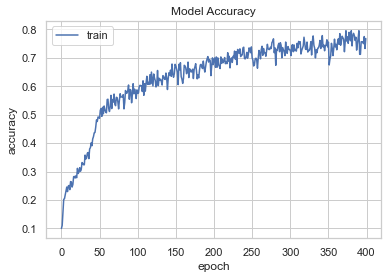

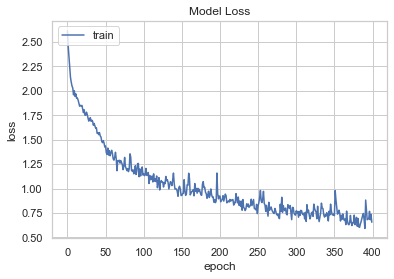

In [17]:
if TEST_MODEL is True:
    ##########################
    # # get model accuracy # #
    ##########################
    plt.plot(history.history['accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

    ######################
    # # get model loss # #
    ######################
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

In [18]:
if TEST_MODEL is True:
    ##########################
    # # view model summary # #
    ##########################
    model.model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 1, 256)            488448    
                                                                 
 dense_25 (Dense)            (None, 1, 256)            65792     
                                                                 
 dropout_20 (Dropout)        (None, 1, 256)            0         
                                                                 
 batch_normalization_15 (Bat  (None, 1, 256)           1024      
 chNormalization)                                                
                                                                 
 lstm_21 (LSTM)              (None, 1, 128)            197120    
                                                                 
 dense_26 (Dense)            (None, 1, 128)            16512     
                                                      

#### MODEL TESTING
- Get Model Accuracy on the Test Dataset
- Generate Confusion Matrix
- Generate ROC Curves
- Save the Model if Appropriate

In [19]:
if TEST_MODEL is True:
    y_pred = model.predict_proba(X_test)

    # evaluate predictions
    acc = accuracy_score(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    print("Testing accuracy: %.3f%%" % (acc*100))

Testing accuracy: 70.000%


##### Confusion Matrix

220 is the number of test value in kfold_val / train_test_split


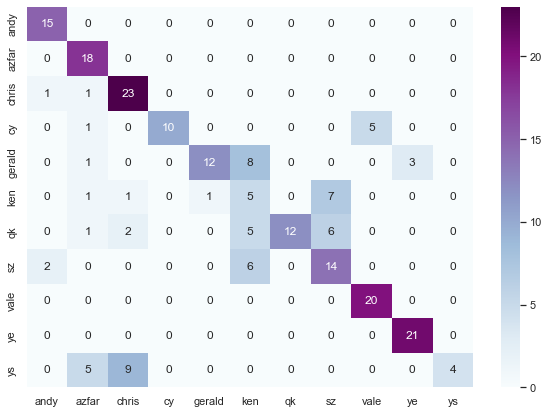

In [20]:
if TEST_MODEL is True and CON_MATRIX is True:
    # confusion matrix
    print(str(len(y_pred)) + " is the number of test value in kfold_val / train_test_split")
    cm = confusion_matrix(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    df_cm = pd.DataFrame(cm, index = [i for i in np.unique(lb.inverse_transform(y_test))],
                         columns = [i for i in np.unique(lb.inverse_transform(y_test))])

    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, cmap="BuPu")

##### ROC Curve (Individual)

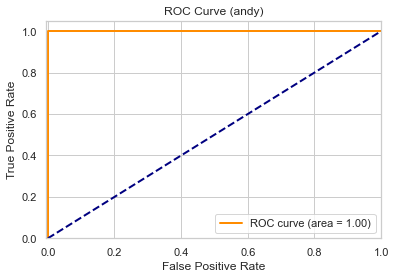

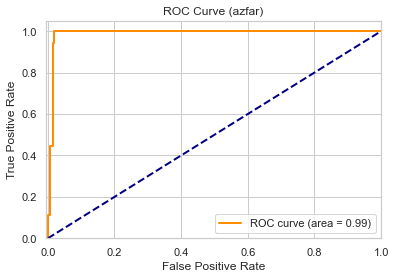

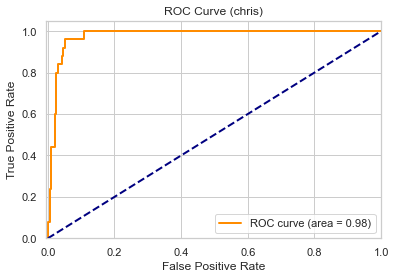

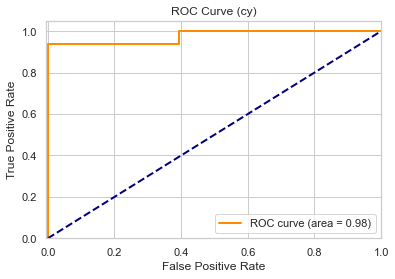

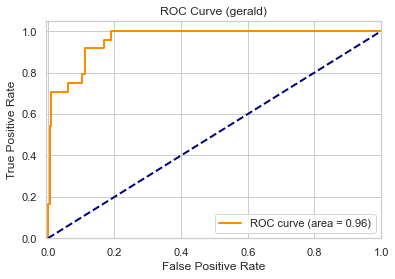

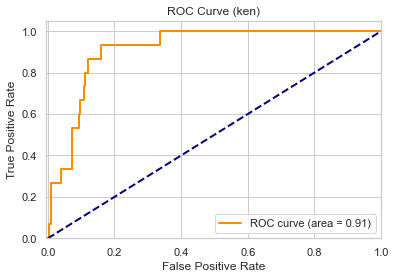

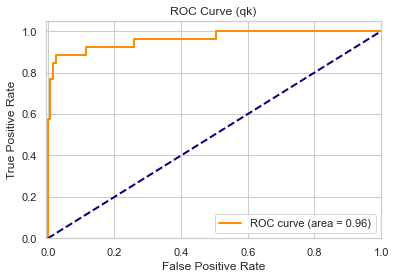

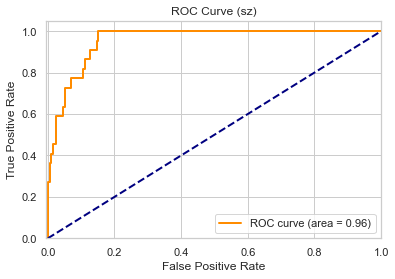

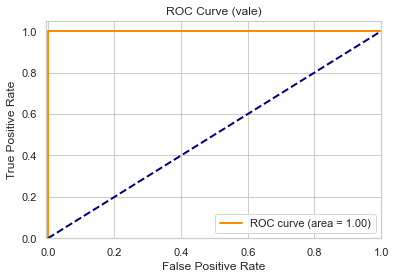

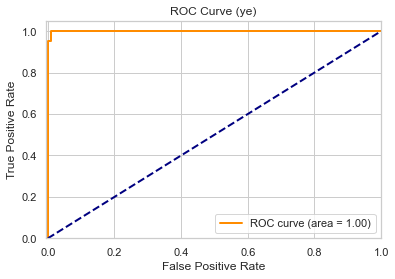

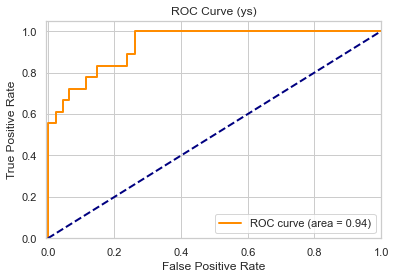

In [21]:
if TEST_MODEL is True and ROC_GRAPH is True: # compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(n_classes):
        plt.figure()
        lw = 2
        plt.plot(
            fpr[i],
            tpr[i],
            color="darkorange",
            lw=lw,
            label="ROC curve (area = %0.2f)" % roc_auc[i],
        )
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        plt.xlim([-0.005, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (" + str(lb.classes_[i]) + ")")
        plt.legend(loc="lower right")
        plt.show()

##### ROC Curve (Multiclass)

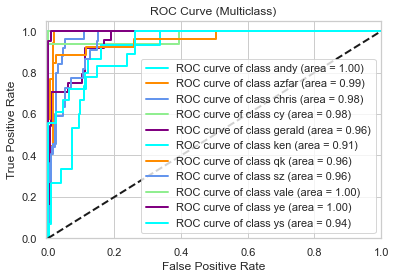

In [22]:
if TEST_MODEL is True and ROC_GRAPH is True:
    # compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], thresholds = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # first aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    # plt.figure()
    # plt.plot(
    #     fpr["micro"],
    #     tpr["micro"],
    #     label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    #     color="deeppink",
    #     linestyle=":",
    #     linewidth=4,
    # )

    # plt.plot(
    #     fpr["macro"],
    #     tpr["macro"],
    #     label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    #     color="navy",
    #     linestyle=":",
    #     linewidth=4,
    # )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "lightgreen", "purple"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(lb.classes_[i], roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([-0.005, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Multiclass)")
    plt.legend(loc="lower right")
    plt.show()

##### ROC Curve (Average)

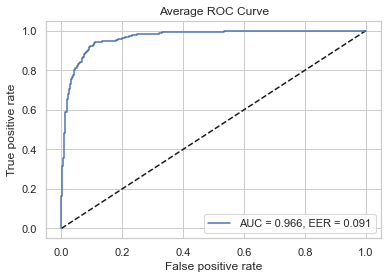

In [23]:
if TEST_MODEL is True and ROC_GRAPH is True:
    fpr, tpr, threshold = roc_curve(y_test.ravel(), y_pred.ravel())

    # calculate equal-error-rate
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='AUC = {:.3f}, EER = {:.3f}'.format(auc(fpr, tpr), eer))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Average ROC Curve')
    plt.legend(loc='best')
    plt.show()

#### FIT AND SAVE MODEL
- Fitting of model
- Get Accuracy and Loss of Mdoel
- Saving Model

In [24]:
############################
# # reshaping of dataset # #
############################
# loading of dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)

df.head()
dataset = df.values

# divide data into features X and target (classes) Y
# convert target Y to labelbinarizer Y for model
X, Y, lb, class_list = prepare_dataset(df)

# reshaping the dataset to include LSTM Timesteps
X = reshape_dataset(X, TIMESTEPS)
n_classes = Y.shape[1]

#####################
# # fit the model # #
#####################

model = create_model()
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                   verbose=0)
history = model.fit(X, Y, callbacks=es)

LabelBinarizer is able to decipher: 
['andy' 'azfar' 'chris' 'cy' 'gerald' 'ken' 'qk' 'sz' 'vale' 'ye' 'ys']


X | Features | Dataset Shape: (1100, 220)
Y | Classes  | Dataset Shape: (1100, 11)
There are a total of 11 classes.
Epoch 1/400
110/110 [==============================] - 7s 11ms/step - loss: 2.5333 - accuracy: 0.0800
Epoch 2/400
110/110 [==============================] - 1s 11ms/step - loss: 2.4271 - accuracy: 0.0791
Epoch 3/400
110/110 [==============================] - 1s 11ms/step - loss: 2.2989 - accuracy: 0.1627
Epoch 4/400
110/110 [==============================] - 1s 11ms/step - loss: 2.1642 - accuracy: 0.1882
Epoch 5/400
110/110 [==============================] - 1s 12ms/step - loss: 2.0711 - accuracy: 0.2109
Epoch 6/400
110/110 [==============================] - 1s 11ms/step - loss: 2.0250 - accuracy: 0.2055
Epoch 7/400
110/110 [==============================] - 1s 12ms/step - loss: 2.0613 - accuracy: 0.2036
Epoch 8/400
110/110 [==============================] - 1s 1

110/110 [==============================] - 1s 11ms/step - loss: 1.2627 - accuracy: 0.5564
Epoch 79/400
110/110 [==============================] - 1s 11ms/step - loss: 1.2381 - accuracy: 0.5573
Epoch 80/400
110/110 [==============================] - 1s 11ms/step - loss: 1.2669 - accuracy: 0.5436
Epoch 81/400
110/110 [==============================] - 1s 12ms/step - loss: 1.2527 - accuracy: 0.5536
Epoch 82/400
110/110 [==============================] - 1s 12ms/step - loss: 1.3186 - accuracy: 0.5200
Epoch 83/400
110/110 [==============================] - 1s 11ms/step - loss: 1.3827 - accuracy: 0.5018
Epoch 84/400
110/110 [==============================] - 1s 12ms/step - loss: 1.3607 - accuracy: 0.5245
Epoch 85/400
110/110 [==============================] - 1s 11ms/step - loss: 1.2515 - accuracy: 0.5382
Epoch 86/400
110/110 [==============================] - 1s 11ms/step - loss: 1.2324 - accuracy: 0.5518
Epoch 87/400
110/110 [==============================] - 1s 11ms/step - loss: 1.2883 - 

110/110 [==============================] - 1s 12ms/step - loss: 0.9636 - accuracy: 0.6518
Epoch 158/400
110/110 [==============================] - 1s 12ms/step - loss: 0.9953 - accuracy: 0.6300
Epoch 159/400
110/110 [==============================] - 1s 12ms/step - loss: 0.9270 - accuracy: 0.6718
Epoch 160/400
110/110 [==============================] - 1s 11ms/step - loss: 0.9885 - accuracy: 0.6736
Epoch 161/400
110/110 [==============================] - 1s 11ms/step - loss: 1.0213 - accuracy: 0.6382
Epoch 162/400
110/110 [==============================] - 1s 11ms/step - loss: 0.9614 - accuracy: 0.6609
Epoch 163/400
110/110 [==============================] - 1s 11ms/step - loss: 0.9348 - accuracy: 0.6609
Epoch 164/400
110/110 [==============================] - 1s 11ms/step - loss: 0.9450 - accuracy: 0.6700
Epoch 165/400
110/110 [==============================] - 1s 13ms/step - loss: 0.9306 - accuracy: 0.6800
Epoch 166/400
110/110 [==============================] - 1s 11ms/step - loss: 

110/110 [==============================] - 1s 11ms/step - loss: 0.8689 - accuracy: 0.7045
Epoch 236/400
110/110 [==============================] - 1s 12ms/step - loss: 0.7988 - accuracy: 0.7227
Epoch 237/400
110/110 [==============================] - 1s 12ms/step - loss: 0.8558 - accuracy: 0.7036
Epoch 238/400
110/110 [==============================] - 1s 11ms/step - loss: 0.8382 - accuracy: 0.7036
Epoch 239/400
110/110 [==============================] - 1s 11ms/step - loss: 0.8520 - accuracy: 0.7055
Epoch 240/400
110/110 [==============================] - 1s 10ms/step - loss: 0.9298 - accuracy: 0.6818
Epoch 241/400
110/110 [==============================] - 1s 11ms/step - loss: 0.8172 - accuracy: 0.7155
Epoch 242/400
110/110 [==============================] - 1s 11ms/step - loss: 0.8298 - accuracy: 0.7136
Epoch 243/400
110/110 [==============================] - 1s 11ms/step - loss: 0.7723 - accuracy: 0.7227
Epoch 244/400
110/110 [==============================] - 1s 11ms/step - loss: 

110/110 [==============================] - 1s 11ms/step - loss: 0.8110 - accuracy: 0.7264
Epoch 314/400
110/110 [==============================] - 2s 16ms/step - loss: 0.6892 - accuracy: 0.7645
Epoch 315/400
110/110 [==============================] - 2s 18ms/step - loss: 0.6536 - accuracy: 0.7764
Epoch 316/400
110/110 [==============================] - 1s 11ms/step - loss: 0.6987 - accuracy: 0.7518
Epoch 317/400
110/110 [==============================] - 2s 16ms/step - loss: 0.6396 - accuracy: 0.7727
Epoch 318/400
110/110 [==============================] - 2s 20ms/step - loss: 0.7917 - accuracy: 0.7291
Epoch 319/400
110/110 [==============================] - 2s 20ms/step - loss: 0.6893 - accuracy: 0.7709
Epoch 320/400
110/110 [==============================] - 2s 16ms/step - loss: 0.6577 - accuracy: 0.7782
Epoch 321/400
110/110 [==============================] - 2s 16ms/step - loss: 0.7142 - accuracy: 0.7500
Epoch 322/400
110/110 [==============================] - 1s 11ms/step - loss: 

110/110 [==============================] - 1s 12ms/step - loss: 0.9070 - accuracy: 0.7145
Epoch 392/400
110/110 [==============================] - 1s 11ms/step - loss: 0.7313 - accuracy: 0.7473
Epoch 393/400
110/110 [==============================] - 1s 11ms/step - loss: 0.6684 - accuracy: 0.7736
Epoch 394/400
110/110 [==============================] - 1s 11ms/step - loss: 0.6390 - accuracy: 0.7627
Epoch 395/400
110/110 [==============================] - 2s 15ms/step - loss: 0.6214 - accuracy: 0.7700
Epoch 396/400
110/110 [==============================] - 1s 12ms/step - loss: 0.7174 - accuracy: 0.7600
Epoch 397/400
110/110 [==============================] - 1s 11ms/step - loss: 0.6304 - accuracy: 0.7764
Epoch 398/400
110/110 [==============================] - 2s 14ms/step - loss: 0.6286 - accuracy: 0.7736
Epoch 399/400
110/110 [==============================] - 1s 12ms/step - loss: 0.5989 - accuracy: 0.7936
Epoch 400/400
110/110 [==============================] - 1s 12ms/step - loss: 

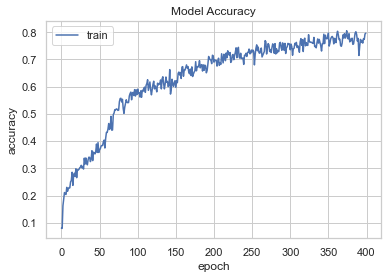

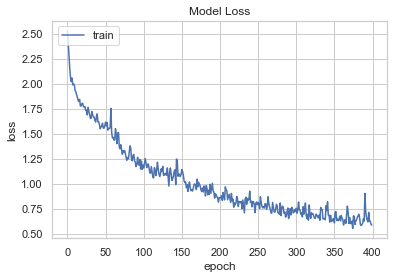

In [25]:
##########################
# # get model accuracy # #
##########################
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

######################
# # get model loss # #
######################
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#### SAVE MODEL

In [26]:
##################
# # save model # #
##################
model.model.save(MODEL_PATH)

# LIVE TESTING
> Live test with new dataset to check if model function as it should

#### LOAD MODEL

In [27]:
##################
# # load model # #
##################

# model = create_model()
model = load_model(MODEL_PATH)

#### LOAD DATA
- Import new dataset to verify the model is able to predict accurately

In [28]:
# import unseen data
pred_df = pd.read_csv(ACTUAL_DATASET_PATH)
pred_df.head()

,Subject,Password,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-NG|0+1,T2-D|1,T2-I|1+2,T2-PF|1+2,...,T7-RF|VAR,T7-NG|VAR,T7-I|SD,T7-PF|SD,T7-RF|SD,T7-NG|SD,T8-I|0+7,T8-PF|0+7,T8-RF|0+7,T8-NG|0+7
0,andy,dEcisi0n,0.112628,0.079001,0.191629,0.189652,0.302280,0.110651,0.057247,0.167898,...,0.009187,0.009457,0.062313,0.063711,0.095848,0.097245,1.136681,1.249309,1.201873,1.314501
1,andy,dEcisi0n,0.102941,0.191321,0.294262,0.280651,0.383592,0.089330,0.089771,0.179101,...,0.022846,0.025848,0.118682,0.128306,0.151149,0.160773,0.989301,1.092242,1.067423,1.170363
2,andy,dEcisi0n,0.114735,0.099664,0.214399,0.212517,0.327251,0.112853,0.101198,0.214051,...,0.016034,0.016373,0.071080,0.072410,0.126627,0.127957,0.888561,1.003296,0.967641,1.082376
3,andy,dEcisi0n,0.113787,0.089431,0.203218,0.178590,0.292377,0.089159,0.057329,0.146488,...,0.006316,0.009388,0.038356,0.055770,0.079475,0.096889,0.832373,0.946160,0.887580,1.001367
4,andy,dEcisi0n,0.121229,0.147608,0.268837,0.248161,0.369389,0.100553,0.068432,0.168985,...,0.018494,0.022685,0.102827,0.117447,0.135994,0.150615,0.879454,1.000683,0.958523,1.079751


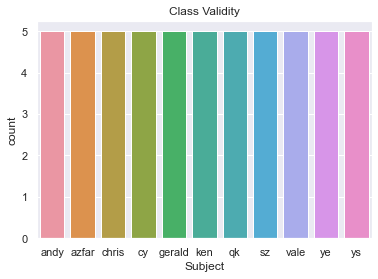

In [29]:
################################
# # check for class validity # #
################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Subject", data=pred_df).set_title("Class Validity")

# remove missing values if available
pred_df = pred_df.dropna()

In [30]:
pred_dataset = pred_df.values
actual_np = pred_dataset[:,CLASSES_COL_NUM]

# # divide data into features X
# pred_row = pred_dataset[:,3:].astype(float)

########################
# # predict all rows # #
########################
pred_row=pred_df.iloc[:,FEATURES_COL_NUM:]

#################################
# # predict more than one row # #
#################################

# pred_row=pred_df.iloc[46:54,FEATURES_COL_NUM:]
# print(pred_row)

############################
# # predict a single row # #
############################

# pred_row=pred_df.iloc[11:12,FEATURES_COL_NUM:]

##################
# # shape data # #
##################
pred_row = pred_row.values.tolist()
pred_arr = np.asarray(pred_row, dtype=np.float32)
pred_arr = np.reshape(pred_arr, (pred_arr.shape[0], TIMESTEPS, pred_arr.shape[1]))

print(class_list)
Y = np.asarray(class_list)
Y = Y.reshape(-1, 1)
lb = LabelBinarizer().fit(Y)
Y = lb.transform(Y)

['andy', 'azfar', 'chris', 'cy', 'gerald', 'ken', 'qk', 'sz', 'vale', 'ye', 'ys']


In [31]:
####################################
# # get prediction and its label # #
####################################

pred_proba = model.predict(pred_arr)

# pred_proba = np.sum(pred_proba, axis=0)
# pred_proba = np.reshape(pred_proba, (1, 9))

pred = lb.inverse_transform(pred_proba)
acc = np.max(pred_proba, axis=1)

match_list = []

for _ in range(actual_np.size):
    if pred[_] == actual_np[_]:
        match_list.append("match")
    else:
        match_list.append("nope")

match_count = match_list.count("match")
total_count = len(match_list)

match_header = str(match_count) + "/" + str(total_count) + " (" + str(match_count/total_count*100)+ "%)"
match_np = np.array(match_list)

exported_output = np.column_stack((actual_np, pred))
exported_output = np.column_stack((exported_output, acc))
exported_output = np.column_stack((exported_output, match_np))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.DataFrame(data=exported_output, index=None, columns=['Actual', 'Prediction', 'Accuracy', match_header])
# print(df)
df.to_csv(RESULT_PATH)

print("Accuracy of the Model is: " + str(match_header))

Accuracy of the Model is: 44/55 (80.0%)


In [32]:
# print elapsed time
elapsed_time = time.time() - start_time
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 00:59:22
